In [1]:
# file-handling
import os 
import json

# user status updates
import time
from time import gmtime, strftime
from tqdm import tqdm
from IPython.display import display, Latex
from datetime import datetime

# the holy trinity of python data science
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# torch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

############ Macros ###############
NP_RANDOM_SEED = 0
TORCH_RANDOM_SEED = 0
np.random.seed(NP_RANDOM_SEED)
torch.manual_seed(TORCH_RANDOM_SEED)

# Physical constants
N = 8 # number of fermions
J = 100 # ~"energy scale" of couplings
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N_DIM = 2**N # Hilbert space dimension 
FIRST_NONZERO = 0.15 # first nonzero eigenvalue, for our intents and purposes

# Computer stuff
if N==8:
    N_SAMPLES = 300 # number of samples to train on
elif N==10:
    N_SAMPLES = 50
else:
    raise NotImplementedError
N_JOBS = 20 # number of jobs to run in parallel

# Model stuff
LR = 1e-7 # learning rate
BATCH_SIZE = 100 # batch size for training the neural network
N_EPOCHS = 5 # number of epochs to train the neural network
R_TRAIN = 0.5 # desired ratio of zero eigenvalues to total eigenvalues IN TRAINING SET
TEST_RANDOM = True # whether to train and test the randomly-trained model
TEST_RANDOM_ACTUAL = False # Allows user to change their mind and not run random model

# Directories
N2_SUSY_DIR = os.path.join("Excel", "N2_SUSY_SYK")
RESULT_DIR = os.path.join(N2_SUSY_DIR, "Simulated Hamiltonians", f"N{N}_J{J}")
MLP_DIR = os.path.join(N2_SUSY_DIR, "MLP", f"N{N}_J{J}")
os.makedirs(MLP_DIR, exist_ok=True)

# 1. Data

##       1.1 Load data

In [2]:
N_IV = N_SAMPLES*N_DIM
ivals_all = np.zeros(shape=(N_IV,), dtype=np.float64)
ivecs_all = np.zeros(shape=(N_IV, N_DIM), dtype=np.complex128)

for i in range(N_SAMPLES):
    ivals_i = np.load(os.path.join(RESULT_DIR, f"ivals_{i}.npy"))
    ivecs_i = np.load(os.path.join(RESULT_DIR, f"ivecs_{i}.npy"))
    ivals_all[i*N_DIM:(i+1)*N_DIM] = ivals_i
    ivecs_all[i*N_DIM:(i+1)*N_DIM,:] = ivecs_i

labels_all = (ivals_all>=FIRST_NONZERO).astype(int) # zero-energy eigenvectors labeled with 0, finite-energy eigenvectors labeled with 1
print(f"ivals_all.shape: {ivals_all.shape}")
print(f"ivecs_all.shape: {ivecs_all.shape}")
print(f"labels_all.shape: {labels_all.shape}")

ivals_all.shape: (76800,)
ivecs_all.shape: (76800, 256)
labels_all.shape: (76800,)


## 1.2 Convert (1xN_DIM) complex into (1x2*N_DIM) real

Torch doesn't currently have handling for complex numbers

In [3]:
ivecs_all_new = np.zeros(shape=(ivecs_all.shape[0], 2*N_DIM), dtype=np.float64)

for i in range(ivecs_all.shape[0]):
    ivecs_all_i = ivecs_all[i]
    ivecs_all_new[i] = np.concatenate((ivecs_all_i.real, ivecs_all_i.imag), axis=0)

ivecs_all = ivecs_all_new
del ivecs_all_new

print(f"ivecs_all.shape = {ivecs_all.shape}")
N_DIM *= 2

ivecs_all.shape = (76800, 512)


## 1.3 Train-test-validate split

In [4]:
# first, random shuffle
shuffler = np.random.permutation(N_IV)
ivecs_all = ivecs_all[shuffler]
labels_all = labels_all[shuffler]

p_train = 0.7
n_train = int(p_train*N_IV)
X_train = ivecs_all[:n_train]
y_train = labels_all[:n_train]

p_val = 0.2
n_val = int(p_val*N_IV)
X_val = ivecs_all[n_train:n_train+n_val]
y_val = labels_all[n_train:n_train+n_val]

p_test = 0.1
n_test = int(p_test*N_IV)
X_test = ivecs_all[n_train+n_val:]
y_test = labels_all[n_train+n_val:]

print(f"X_train.shape = {X_train.shape}")

X_train.shape = (53760, 512)


## 1.4 Load extra zero-energy data to balance training dataset, if specified

In [5]:
if N==8:
    N_EXTRA = 100
elif N==10:
    N_EXTRA = 20
else:
    raise NotImplementedError

LOAD_EXTRA_ZEROS = True
if LOAD_EXTRA_ZEROS:

    # Load the data 
    ivals_all_0 = []
    ivecs_all_0 = []
    for i in range(N_SAMPLES, N_SAMPLES+N_EXTRA):
        ivals_i = np.load(os.path.join(RESULT_DIR, f"ivals_{i}.npy"))
        ivecs_i = np.load(os.path.join(RESULT_DIR, f"ivecs_{i}.npy"))

        ivals_i_0_idx = np.where(ivals_i < FIRST_NONZERO)[0]
        #print(f"ivals_i_0_idx = {ivals_i_0_idx}")
        ivals_i_0 = [ivals_i[i] for i in ivals_i_0_idx]
        ivecs_i_0 = [ivecs_i[i,:] for i in ivals_i_0_idx]
        ivals_all_0.extend(ivals_i_0)
        ivecs_all_0.extend(ivecs_i_0)

    ivals_all_0 = np.array(ivals_all_0)
    ivecs_all_0 = np.array(ivecs_all_0)

    # Reshape complex 1xN_DIM into real 2xN_DIM
    ivecs_all_0_new = np.zeros(shape=(ivecs_all_0.shape[0], N_DIM), dtype=np.float64)
    for i in range(ivecs_all_0.shape[0]):
        ivecs_all_0_i = ivecs_all_0[i]
        ivecs_all_0_new[i] = np.concatenate((ivecs_all_0_i.real, ivecs_all_0_i.imag), axis=0)
    ivecs_all_0 = copy.deepcopy(ivecs_all_0_new)
    del ivecs_all_0_new
    print(f"ivals_all_0.shape = {ivals_all_0.shape}")
    print(f"ivecs_all_0.shape = {ivecs_all_0.shape}")

    X_train_0 = ivecs_all_0
    y_train_0 = np.array(ivals_all_0 < FIRST_NONZERO, dtype=np.int64)
    X_train = np.concatenate((X_train, X_train_0), axis=0)
    y_train = np.concatenate((y_train, y_train_0), axis=0)

    print(f"X_train.shape = {X_train.shape}")
    print(f"y_train.shape = {y_train.shape}")

ivals_all_0.shape = (10800,)
ivecs_all_0.shape = (10800, 512)
X_train.shape = (64560, 512)
y_train.shape = (64560,)


## 1.5 Balance training set

$r_{train} = $ desired proportion of zero-energy eigenvectors

$N_0 =$ number of zero-energy eigenvectors

$N_f =$ number of finite-energy eigenvectors

$N_{add}$ number of zero-energy eigenvectors we must add to achieve $r_{want}$



   :


To find $N_{add}$, we start off with an identity:

$r_{train} \equiv \frac{N_0+N_{add}}{N_0+N_f+N_{add}} $

$N_0+N_{add} = r_{train} (N_0+N_f+N_{add})$

$N_0+N_{add} = r_{train}*N_0+r_{train}*N_f+r_{train}*N_{add}$

$N_{add}(1-r_{train}) = N_0(r_{train}-1)+r_{train}*N_f$


And finally,

$N_{add} = \frac{N_0(r_{train}-1)+N_f*r_{train}}{1-r_{train}}$

In [6]:
N_0 = sum(y_train==0)
N_f = sum(y_train==1)
N_add = (N_0*(R_TRAIN-1)+N_f*R_TRAIN)/(1-R_TRAIN)

X_train_0 = X_train[y_train==0]
X_train_0_clone_idx = np.random.choice(range(X_train_0.shape[0]), size=int(N_add), replace=True)
X_train_0_clone = copy.deepcopy(X_train_0[X_train_0_clone_idx])
y_train_0_clone = np.zeros(shape=(X_train_0_clone.shape[0],), dtype=np.int32)

X_train = np.concatenate((X_train, X_train_0_clone), axis=0)
y_train = np.concatenate((y_train, y_train_0_clone), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"N_0: {sum(y_train==0)/len(y_train)}")

X_train.shape: (83590, 512)
N_0: 0.5


## 1.6 Scale data

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"X_test.shape: {X_test.shape}")


X_train.shape: (83590, 512)
X_val.shape: (15360, 512)
X_test.shape: (7680, 512)


## 1.7 Convert to Torch tensors that MLP can read

In [9]:
X_train = torch.from_numpy(X_train).float().cuda()
y_train = torch.from_numpy(y_train).float().cuda()

X_val = torch.from_numpy(X_val).float().cuda()
y_val = torch.from_numpy(y_val).float().cuda()

X_test = torch.from_numpy(X_test).float().cuda()
y_test = torch.from_numpy(y_test).float().cuda()

# 2. MLP

In [10]:
class BinaryClassifier_N8(nn.Module):
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim):
        
        super(BinaryClassifier_N8, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden1_dim)
        self.layer2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.layer3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.layer4 = nn.Linear(hidden3_dim, output_dim)

    # Function to pass data forward through network.
    def forward(self, x):
        out1 = F.relu(self.layer1(x))
        out2 = F.relu(self.layer2(out1))
        out3 = F.relu(self.layer3(out2))
        out4 = F.sigmoid(self.layer4(out3))
        return out4

class BinaryClassifier_N10(nn.Module):
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, hidden5_dim):
        
        super(BinaryClassifier_N10, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden1_dim)
        self.layer2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.layer3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.layer4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.layer5 = nn.Linear(hidden4_dim, hidden5_dim)
        self.layer6 = nn.Linear(hidden5_dim, output_dim)

    # Function to pass data forward through network.
    def forward(self, x):
        out1 = F.relu(self.layer1(x))
        out2 = F.relu(self.layer2(out1))
        out3 = F.relu(self.layer3(out2))
        out4 = F.relu(self.layer4(out3))
        out5 = F.relu(self.layer5(out4))
        out6 = F.sigmoid(self.layer6(out5))
        return out6

# Initialize model and random model 
if N==8:
    model = BinaryClassifier_N8(N_DIM, 1, 1500, 500, 100, 10)
    model_random = BinaryClassifier_N8(N_DIM, 1, 1500, 500, 100, 10)
elif N==10:
    model = BinaryClassifier_N10(N_DIM, 1, 6000, 1500, 500, 100, 10)
    model_random = BinaryClassifier_N10(N_DIM, 1, 6000, 1500, 500, 100, 10)
else:
    raise NotImplementedError

print(f"model: {model._modules}")
model.cuda()
model_random.cuda()

# If you re-instantiate the models, must restart the run counters, run dicts, and loss lists.
RUN_COUNTER = 0 
RUNS_DICT = {}
RUNS_DICT_RANDOM = {}

mean_train_loss_list = []
train_loss_list = []
val_acc_list = []
pos_pred_list = []

mean_train_loss_list_random = []
train_loss_list_random = []
val_acc_list_random = []
pos_pred_list_random = []

model: OrderedDict([('layer1', Linear(in_features=512, out_features=1500, bias=True)), ('layer2', Linear(in_features=1500, out_features=500, bias=True)), ('layer3', Linear(in_features=500, out_features=100, bias=True)), ('layer4', Linear(in_features=100, out_features=1, bias=True))])


# 3. Train

## 3.1 Define training function

In [11]:
def train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, batch_size, n_epochs):
    mean_train_loss_list = []
    train_loss_list = []
    validation_acc_list = []
    pos_pred_list = []
    n_batch = X_train.shape[0]//batch_size

    tic = time.time()
    for i in tqdm(range(n_epochs)):
        # shuffle samples
        shuffler = np.random.permutation(X_train.shape[0])
        X_train = X_train[shuffler]
        y_train = y_train[shuffler]

        optimizer.zero_grad()

        train_loss_i = []
        val_acc_i = []
        pos_pred_i = []

        for j in range(n_batch):
            X_i = X_train[j*batch_size:(j+1)*batch_size]
            y_i = y_train[j*batch_size:(j+1)*batch_size]

            # Forward pass
            output = torch.squeeze(model(X_i))
            loss_ij = loss_func(output, y_i)
            train_loss_i.append(loss_ij.item())

            loss_ij.backward()
            optimizer.step()

            with torch.no_grad():
                # Validation accuracy
                output_val = torch.round(torch.squeeze(model(X_val))).detach().cpu().numpy()

                val_acc_ij = (output_val == y_val.detach().cpu().numpy()).sum()/y_val.shape[0]
                val_acc_i.append(val_acc_ij)

                pos_pred_ij = sum(output_val)/len(output_val)
                pos_pred_i.append(pos_pred_ij)

        mean_train_loss_list.append(np.mean(np.array(train_loss_i)))
        train_loss_list.extend(train_loss_i)
        validation_acc_list.extend(val_acc_i)
        pos_pred_list.extend(pos_pred_i)
    
    duration = time.time() - tic
    print(f"Training: {duration//60} minutes, {duration%60} seconds")
    return mean_train_loss_list, train_loss_list, validation_acc_list, pos_pred_list

## 3.2 If you'd like to load a pretrained model and simply pick up there

In [12]:
TEST_RANDOM_ACTUAL = True
if N==8:
    PRETRAINED_RUN = 3
elif N==10:
    PRETRAINED_RUN = 26
else:
    raise NotImplementedError
PRETRAINED_RUN_DIR = os.path.join(MLP_DIR, f"run_{PRETRAINED_RUN}")

# Model
model_state_dict = torch.load(os.path.join(PRETRAINED_RUN_DIR, "model.pt"))
model.load_state_dict(model_state_dict)

# Metric tracking
mean_train_loss_list = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "mean_loss.npy"))]
train_loss_list = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "loss.npy"))]
val_acc_list = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "acc.npy"))]
pos_pred_list = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "ppos.npy"))]

# Run dict
with open(os.path.join(PRETRAINED_RUN_DIR, f"RUNS_DICT.json"), "r") as f:
    RUNS_DICT = json.load(f)
RUNS_DICT = {int(k): v for k, v in RUNS_DICT.items()}
RUN_COUNT = max(RUNS_DICT.keys())

# Load random model, if it exists
if TEST_RANDOM and TEST_RANDOM_ACTUAL:
    model_random_state_dict = torch.load(os.path.join(PRETRAINED_RUN_DIR, "model_random.pt"))
    model_random.load_state_dict(model_random_state_dict)

    mean_train_loss_list_random = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "mean_loss_random.npy"))]
    train_loss_list_random = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "loss_random.npy"))]
    val_acc_list_random = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "acc_random.npy"))]
    pos_pred_list_random = [i for i in np.load(os.path.join(PRETRAINED_RUN_DIR, "ppos_random.npy"))]
    RUNS_DICT_RANDOM = copy.deepcopy(RUNS_DICT)

## 3.3 Train model

In [13]:
# lr_run = LR/10
# n_ep_run = N_EPOCHS
# bs_run = BATCH_SIZE*2

# optimizer = torch.optim.Adam(model.parameters(), lr=lr_run)
# loss_func = nn.BCELoss()
# mean_train_loss_list_run, train_loss_list_run, val_acc_list_run, pos_pred_list_run = train(model, optimizer, loss_func, X_train, y_train, X_val, y_val, bs_run, n_ep_run)
# mean_train_loss_list.extend(mean_train_loss_list_run)
# train_loss_list.extend(train_loss_list_run)
# val_acc_list.extend(val_acc_list_run)
# pos_pred_list.extend(pos_pred_list_run)

# RUN_COUNTER += 1
# RUNS_DICT[RUN_COUNTER] = {"Number of epochs": n_ep_run, "Learning rate": lr_run, "Batch size": bs_run}
# for k,v in RUNS_DICT[RUN_COUNTER].items():
#     print(f"{k}: {v}")

# 4. Evaluation

## 4.1 Plot loss, validation accuracy

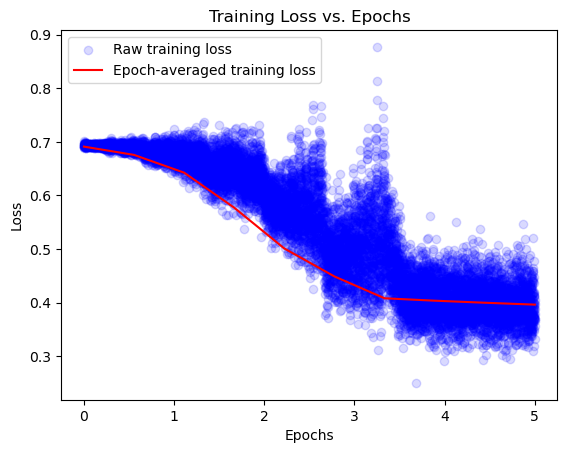

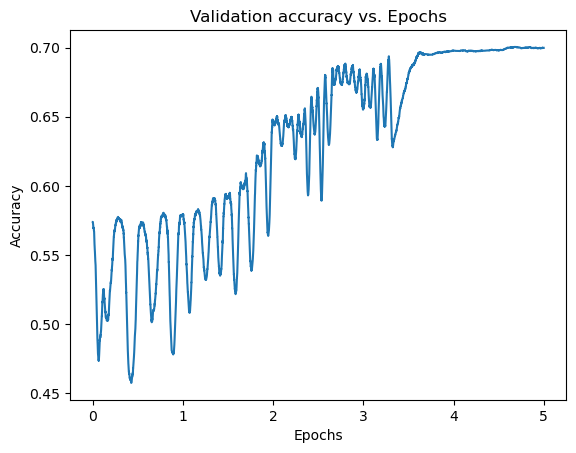

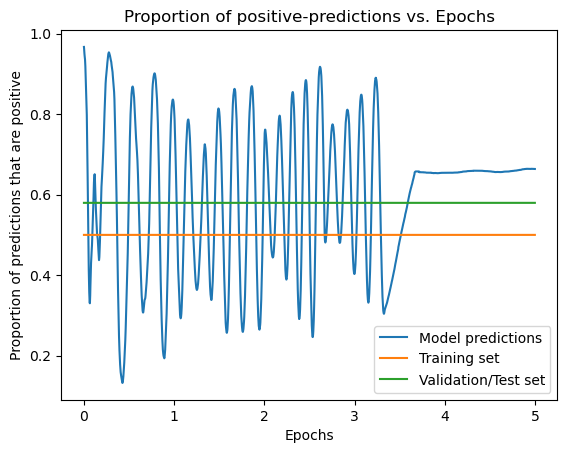

In [14]:
n_epochs_actual = 0
for run, run_dict in RUNS_DICT.items():
    n_epochs_actual += run_dict["Number of epochs"]

mean_train_xrange = np.linspace(0, len(train_loss_list), len(mean_train_loss_list))
fig_loss = plt.figure()
plt.scatter(range(len(train_loss_list)), train_loss_list, alpha=0.15, label="Raw training loss", c="b")
plt.plot(mean_train_xrange, mean_train_loss_list, label="Epoch-averaged training loss", c="r")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss vs. Epochs")

fig_acc = plt.figure()
plt.plot(range(len(val_acc_list)), val_acc_list)
plt.ylabel("Accuracy")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
plt.xlabel("Epochs")
plt.title("Validation accuracy vs. Epochs")

fig_ppos = plt.figure()
plt.plot(range(len(pos_pred_list)), pos_pred_list, label="Model predictions")
plt.plot(range(len(pos_pred_list)), [1-R_TRAIN for i in pos_pred_list], label="Training set")
R_VAL = (sum(y_val)/len(y_val)).item()
plt.plot(range(len(pos_pred_list)), [R_VAL for i in pos_pred_list], label="Validation/Test set")
plt.ylabel("Proportion of predictions that are positive")
plt.xticks(ticks=np.linspace(0, len(train_loss_list), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
plt.xlabel("Epochs")
plt.title("Proportion of positive-predictions vs. Epochs")
plt.legend()


## 4.2 Evaluate performance on validation-set, with Monte-Carlo p-values controlling for the same ratio of 0's to 1's

For the Monte-Carlo p-values, we're basically checking: what are the odds of getting this level of performance by simply guessing 0's or 1's at random at the same proportion as the trained neural network? 

So the null hypothesis is:
- The neural network only learned to predict a certain ratio of 0's-to-1's in order to minimize the loss function. 

And the alternative hypothesis is:
- The neural network learned an actual (latent) structure/relationship within/between the zero-energy and finite-energy eigenvectors. 

If the null hypothesis is true, we should expect that randomly choosing 0's or 1's - at the same ratio as the trained model - should give similar performance to the trained model. Looking at the Monte-Carlo distribution of performance metrics (i.e. accuracy, precision, recall, F1), the performance of the trained model should not be too far from average. 


If the alternative hypothesis is true, randomly choosing 0's or 1's at the same ratio as the trained model will not reproduce the trained model's performance. The neural network's performance metrics should not seem average within the Monte-Carlo distribution of performance metrics. We choose significance level p=0.05

First, some helper functions

In [15]:
# Computes binary classification performance metrics
def get_metrics(y_true, y_pred): 
    true_pos = sum((y_pred==y_true)&(y_pred==1))
    true_neg = sum((y_pred==y_true)&(y_pred==0))
    false_pos = sum((y_pred!=y_true)&(y_pred==1))
    false_neg = sum((y_pred!=y_true)&(y_pred==0))

    acc = (true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
    prec = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    f1 = 2*prec*recall/(prec+recall)
    return acc, prec, recall, f1

# Generates random binary monte-carlo predictions, with the given probability of a positive prediction
def monte_carlo_bin_pred(sample_size, n_samples, p_pos_pred, vary_p_pos): 
    mc_predictions = np.zeros(shape=(n_samples, sample_size))
    for i in range(n_samples):
        if vary_p_pos:
            p_pos_pred_i = np.random.choice(np.linspace(max(0, p_pos_pred-vary_p_pos), min(p_pos_pred+vary_p_pos,1), 100), size=1)[0]
            pred_i = np.random.choice([0, 1], size=sample_size, p=[1-p_pos_pred_i, p_pos_pred_i])
        else:
            pred_i = np.random.choice([0, 1], size=sample_size, p=[1-p_pos_pred, p_pos_pred])
        mc_predictions[i] = pred_i
    return mc_predictions

# Computes (distribution of) monte-carlo performance metrics
def monte_carlo_performance(y_truth, mc_preds, plots): 
    n_mc_samples = mc_preds.shape[0]

    acc = np.zeros(shape=(n_mc_samples))
    prec = np.zeros(shape=(n_mc_samples))
    recall = np.zeros(shape=(n_mc_samples))
    f1 = np.zeros(shape=(n_mc_samples))
    for i in range(n_mc_samples):
        acc[i], prec[i], recall[i], f1[i] = get_metrics(mc_preds[i], y_truth) 

    if plots:
        plt.figure()
        plt.hist(acc, bins=40)
        plt.title("Monte-Carlo Accuracy")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(prec, bins=40)
        plt.title("Monte-Carlo Precision")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(recall, bins=40)
        plt.title("Monte-Carlo Recall")
        plt.show()
        plt.close()

        plt.figure()
        plt.hist(f1, bins=40)
        plt.title("Monte-Carlo F1-Scores")
        plt.show()
        plt.close()

    mc_performance_dict = {"Accuracy": acc,
                "Precision": prec,
                "Recall": recall,
                "F1": f1}
    return mc_performance_dict
    
# Computes performance metric of given predictions, and the monte-carlo p-values of those metrics
def get_performance(y_truth, y_pred, mc_performance_dict, plots=False):

    acc, prec, recall, f1 = get_metrics(y_truth, y_pred) # model performance metrics 
    
    # monte carlo performance metrics
    mc_acc = mc_performance_dict["Accuracy"]
    mc_prec = mc_performance_dict["Precision"]
    mc_recall = mc_performance_dict["Recall"]
    mc_f1 = mc_performance_dict["F1"]

    n_mc_samples = len(mc_acc) # number of monte carlo samples
    p_acc = (np.sum(acc < mc_acc)+1)/(n_mc_samples+1) # Accyracy p-value
    p_prec = (np.sum(prec < mc_prec)+1)/(n_mc_samples+1) # Precision p-value
    p_recall = (np.sum(recall < mc_recall)+1)/(n_mc_samples+1) # Recall p-value
    p_f1 = (np.sum(f1 < mc_f1)+1)/(n_mc_samples+1) # F1 p-value

    

    performance_dict = {"Accuracy": (acc, p_acc),
                        "Precision": (prec, p_prec),
                        "Recall": (recall, p_recall),
                        "F1": (f1, p_f1)}
    return performance_dict

Predicted proportion of 1's (validation): 0.66
True proportion of 1's (validation): 0.58

Trained model performance:
  Accuracy: (69.97%, p=0.00010)
  Precision: (71.04%, p=0.00010)
  Recall: (81.35%, p=0.00010)
  F1: (75.85%, p=0.00010)
  AUC: (77.25%, p=nan)


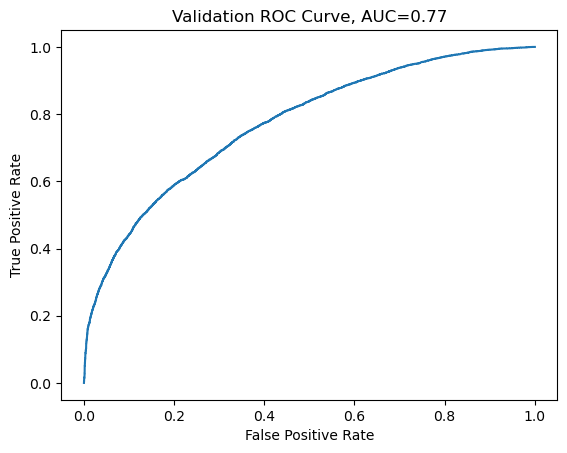

In [15]:
PLOTS = False # Whether to plot Monte-Carlo distributions
VARY_P_POS = None # Amount by which the Monte-Carlo predictions should vary from the model's prediction of the proportion of positive predictions. If None, then no variation
# TO-DO: If VARY_P_POS is not None, then what distribution should we choose from? Uniform? Gaussian? Beta?

# Generate test predictions
with torch.no_grad():
    output_val = torch.squeeze(model(X_val))
    output_val_round = torch.round(output_val)
p_pos_pred_val = sum(output_val_round==1)/len(output_val) # Predicted proportion of 1's, use these for Monte-Carlo simulations
p_pos_true_val = sum(y_val==1)/len(y_val) # True proportion of 1's
print(f"Predicted proportion of 1's (validation): {p_pos_pred_val:.2f}")
print(f"True proportion of 1's (validation): {p_pos_true_val:.2f}")

# Generate Monte-Carlo predictions and performance metrics
MC_PREDICTIONS_VAL = monte_carlo_bin_pred(len(y_val), int(1e4), p_pos_pred_val.item(), vary_p_pos=VARY_P_POS)
MC_PERFORMANCE_DICT_VAL = monte_carlo_performance(y_val.cpu().numpy(), MC_PREDICTIONS_VAL, plots=PLOTS)

# Get model's performance metrics, with p-values based on Monte-Carlo simulations
performance_dict_val = get_performance(y_val.cpu().numpy(), output_val_round.cpu().numpy(), MC_PERFORMANCE_DICT_VAL, plots=PLOTS)

# Get AUC score, generate ROC curve
auc_val = roc_auc_score(y_val.cpu().numpy(), output_val.cpu().numpy())
fpr, tpr, thresholds = roc_curve(y_val.cpu().numpy(), output_val.cpu().numpy())
performance_dict_val["AUC"] = (auc_val, np.nan)
fig_roc_val = plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Validation ROC Curve, AUC={auc_val:.2f}")

# Display performance metrics
print(f"\nTrained model performance:")
for key, value in performance_dict_val.items():
    print(f"  {key}: ({100*value[0]:.2f}%, p={value[1]:.5f})")

## 4.3 Evaluate performance on test-set, again with Monte-Carlo p-values

In [ ]:
PLOTS = False # Whether to plot Monte-Carlo distributions
VARY_P_POS = None # Amount by which the Monte-Carlo predictions should vary from the model's prediction of the proportion of positive predictions. If None, then no variation
# TO-DO: If VARY_P_POS is not None, then what distribution should we choose from? Uniform? Gaussian? Beta?

# Generate test predictions
with torch.no_grad():
    output_test = torch.squeeze(model(X_test))
    output_test_round = torch.round(output_test)
p_pos_pred_test = sum(output_test_round==1)/len(output_test) # Predicted proportion of 1's, use these for Monte-Carlo simulations
p_pos_true_test = sum(y_test==1)/len(y_test) # True proportion of 1's
print(f"Predicted proportion of 1's (test): {p_pos_pred_test:.2f}")
print(f"True proportion of 1's (test): {p_pos_true_test:.2f}")

# Generate Monte-Carlo predictions and performance metrics
MC_PREDICTIONS = monte_carlo_bin_pred(len(y_test), int(1e4), p_pos_pred_test.item(), vary_p_pos=VARY_P_POS)
MC_PERFORMANCE_DICT = monte_carlo_performance(y_test.cpu().numpy(), MC_PREDICTIONS, plots=PLOTS)

# Get model's performance metrics, with p-values based on Monte-Carlo simulations
performance_dict = get_performance(y_test.cpu().numpy(), output_test_round.cpu().numpy(), MC_PERFORMANCE_DICT, plots=PLOTS)

# Get AUC score, generate ROC curve
auc = roc_auc_score(y_test.cpu().numpy(), output_test.cpu().numpy())
fpr, tpr, thresholds = roc_curve(y_test.detach().cpu().numpy(), output_test.detach().cpu().numpy())
performance_dict["AUC"] = (auc, np.nan)
fig_roc = plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Trained-model ROC Curve, AUC={auc:.2f}")

# Display performance metrics
print(f"\nTrained model performance:")
for key, value in performance_dict.items():
    print(f"  {key}: ({100*value[0]:.2f}%, p={value[1]:.5f})")

## 4.4 Compare to randomly-trained model

In [ ]:
#torch.cuda.empty_cache()
if TEST_RANDOM:
    
    to_do = {k:v for k,v in RUNS_DICT.items() if k not in RUNS_DICT_RANDOM}
    print(f"To do: {to_do}")
    # 1. Train random model for same epochs, learning rate as true model
    for run, run_dict in RUNS_DICT.items():
        if run in RUNS_DICT_RANDOM:
            continue

        # Create random labels 
        shuffler = np.random.permutation(y_train.shape[0])
        y_train_random = y_train[shuffler]

        optimizer_random = torch.optim.Adam(model_random.parameters(), lr=run_dict["Learning rate"])
        loss_func = nn.BCELoss()
        mean_train_loss_list_random_run, train_loss_list_random_run, val_acc_list_random_run, pos_pred_list_random_run = train(model_random, optimizer_random, loss_func, X_train, y_train_random, X_val, y_val, run_dict["Batch size"], run_dict["Number of epochs"])
        mean_train_loss_list_random.extend(mean_train_loss_list_random_run)
        train_loss_list_random.extend(train_loss_list_random_run)
        val_acc_list_random.extend(val_acc_list_random_run)
        pos_pred_list_random.extend(pos_pred_list_random_run)

        RUNS_DICT_RANDOM[run] = RUNS_DICT[run].copy()

    ## 2. Plot loss, validation accuracy
    mean_train_xrange_random = np.linspace(0, len(train_loss_list_random), len(mean_train_loss_list_random))
    fig_loss_random = plt.figure()
    plt.scatter(range(len(train_loss_list_random)), train_loss_list_random, alpha=0.15, c="b", label="Raw training loss")
    plt.plot(mean_train_xrange_random, mean_train_loss_list_random, c="r", label="Epoch-averaged training loss")
    plt.ylabel("Loss")
    plt.xticks(ticks=np.linspace(0, len(train_loss_list_random), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
    plt.xlabel("Epochs")
    plt.legend()
    plt.title("Random Model: Training Loss vs. Epochs")

    fig_acc_random = plt.figure()
    plt.plot(range(len(val_acc_list_random)), val_acc_list_random)
    plt.ylabel("Accuracy")
    plt.xticks(ticks=np.linspace(0, len(train_loss_list_random), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
    plt.xlabel("Epochs")
    plt.title("Random Model: Validation Accuracy vs. Epochs")

    fig_ppos_random = plt.figure()
    plt.plot(range(len(pos_pred_list_random)), pos_pred_list_random, label="Model predictions")
    plt.plot(range(len(pos_pred_list_random)), [1-R_TRAIN for i in pos_pred_list_random], label="Training set")
    R_VAL = (sum(y_val)/len(y_val)).item()
    plt.plot(range(len(pos_pred_list_random)), [R_VAL for i in pos_pred_list_random], label="Validation/Test set")
    plt.ylabel("Proportion of predictions that are positive")
    plt.xticks(ticks=np.linspace(0, len(train_loss_list_random), n_epochs_actual+1), labels=[f"{i}" for i in range(n_epochs_actual+1)])
    plt.xlabel("Epochs")
    plt.title("Random Model: Proportion of positive-predictions vs. Epochs")
    plt.legend()

    # 3. Evaluate on test-set, with p-values based on Monte-Carlo simulations

    # 3.a. Generate test predictions
    with torch.no_grad():
        output_test_random = torch.squeeze(model_random(X_test))
        output_test_random_round = torch.round(output_test_random)
    p_pos_pred_random = sum(output_test_random_round==1)/len(output_test_random) # Predicted proportion of 1's, use these for Monte-Carlo simulations
    print(f"Predicted proportion of 1's: {p_pos_pred_random:.2f}")
    print(f"True proportion of 1's: {p_pos_true_test:.2f}")

    # 3.b. Generate Monte-Carlo predictions and performance metrics
    MC_PREDICTIONS_RANDOM = monte_carlo_bin_pred(len(y_test), int(1e4), p_pos_pred_random.item(), vary_p_pos=VARY_P_POS)
    MC_PERFORMANCE_DICT_RANDOM = monte_carlo_performance(y_test.cpu().numpy(), MC_PREDICTIONS_RANDOM, plots=False)

    # 3.c. Get model's performance metrics, with p-values based on Monte-Carlo simulations
    performance_dict_random = get_performance(y_test.cpu().numpy(), output_test_random.cpu().numpy(), MC_PERFORMANCE_DICT_RANDOM, plots=PLOTS)

    # 3.d. Get AUC score, generate ROC curve
    auc_random = roc_auc_score(y_test.cpu().numpy(), output_test_random.cpu().numpy())
    fpr_random, tpr_random, thresholds_random = roc_curve(y_test.detach().cpu().numpy(), output_test_random.detach().cpu().numpy())
    performance_dict_random["AUC"] = (auc_random, 0)
    fig_roc_random = plt.figure()
    plt.plot(fpr_random, tpr_random)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Random model ROC Curve, AUC={auc_random:.2f}")

    # 3.e. Display performance metrics
    print(f"\nRandom model performance:")
    for key, value in performance_dict_random.items():
        print(f"  {key}: ({100*value[0]:.2f}%, p={value[1]:.5f})")
    
    TEST_RANDOM_ACTUAL = True

# 5. Save everything

In [ ]:
# prev_runs = [int(i.split("_")[1].replace(".pt","")) for i in os.listdir(MLP_DIR) if os.path.isdir(os.path.join(MLP_DIR,i))]
# if len(prev_runs) == 0:
#     max_run = 0
# else:
#     max_run = np.max(np.array(prev_runs))
# RUN_DIR = os.path.join(MLP_DIR, f"run_{max_run+1}")
# os.makedirs(RUN_DIR, exist_ok=False)
# print(f"RUN_DIR: {RUN_DIR}")

# torch.save(model.state_dict(), os.path.join(RUN_DIR, "model.pt"))
# torch.save(model_random.state_dict(), os.path.join(RUN_DIR, "model_random.pt"))

# with open(os.path.join(RUN_DIR, "about.txt"), "w") as f:
#     # Random seeds for reproducibility
#     f.write(f"Numpy random seed: {NP_RANDOM_SEED}")
#     f.write(f"\nTorch random seed: {TORCH_RANDOM_SEED}")
    
#     # Physical constants
#     f.write(f"\n\nN: {N}\nJ: {J}\nFIRST_NONZERO: {FIRST_NONZERO}") 

#     # Training parameter
#     f.write(f"\n\nModel: {model._modules}\nN_SAMPLES: {N_SAMPLES}\nR_TRAIN: {R_TRAIN}\nP_POS_TRUE: {p_pos_true_test}") # model parameters
#     f.write("\nRUNS_DICT")
#     for k, v in RUNS_DICT.items():
#         f.write(f"\n  {k}: {v}")

#     # Model performance
#     f.write("\n\nPerformance at " + f"VARY_P_POS = {VARY_P_POS}")
#     for k, v in performance_dict.items():
#         f.write(f"\n  {k}: ({100*v[0]:.2f}%, p={v[1]})")
#     f.write(f"\n  p-pos pred: {p_pos_pred_test}")

#     # Random model performance
#     if TEST_RANDOM and TEST_RANDOM_ACTUAL:
#         f.write("\n\nRANDOM MODEL Performance at " + f"VARY_P_POS = {VARY_P_POS}")
#         for k, v in performance_dict_random.items():
#             f.write(f"\n  {k}: ({100*v[0]:.2f}%, p={v[1]})")
#         f.write(f"\n  p-pos pred: {p_pos_pred_random}")

# fig_loss.savefig(os.path.join(RUN_DIR, "loss.png"))
# fig_acc.savefig(os.path.join(RUN_DIR, "acc.png"))
# fig_ppos.savefig(os.path.join(RUN_DIR, "ppos.png"))
# fig_roc.savefig(os.path.join(RUN_DIR, "roc.png"))
# np.save(os.path.join(RUN_DIR, "mean_loss.npy"), np.array(mean_train_loss_list))
# np.save(os.path.join(RUN_DIR, "loss.npy"), np.array(train_loss_list))
# np.save(os.path.join(RUN_DIR, "acc.npy"), np.array(val_acc_list))
# np.save(os.path.join(RUN_DIR, "ppos.npy"), np.array(pos_pred_list))

# if TEST_RANDOM and TEST_RANDOM_ACTUAL:
#     fig_loss_random.savefig(os.path.join(RUN_DIR, "loss_random.png"))
#     fig_acc_random.savefig(os.path.join(RUN_DIR, "acc_random.png"))
#     fig_ppos_random.savefig(os.path.join(RUN_DIR, "ppos_random.png"))
#     fig_roc_random.savefig(os.path.join(RUN_DIR, "roc_random.png"))
#     np.save(os.path.join(RUN_DIR, "mean_loss_random.npy"), np.array(mean_train_loss_list_random))
#     np.save(os.path.join(RUN_DIR, "loss_random.npy"), np.array(train_loss_list_random))
#     np.save(os.path.join(RUN_DIR, "acc_random.npy"), np.array(val_acc_list_random))
#     np.save(os.path.join(RUN_DIR, "ppos_random.npy"), np.array(pos_pred_list_random))

# with open(os.path.join(RUN_DIR, f"RUNS_DICT.json"), "w") as f:
#     json.dump(RUNS_DICT, f)